In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

from data_loading import (load_m1h_activation_data,
                          load_annotated_6k_collection)

In [2]:
m1h = load_m1h_activation_data()
tfs = load_annotated_6k_collection()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)

# TODO move to data_loading.py
df = pd.read_csv("../output/TF-iso_ref-vs-alt.tsv", sep="\t")
df['ref_iso'] = df['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['alt_iso'] = df['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['f_disorder_difference'] = df.apply(lambda x: tfs[x['gene_symbol']].disordered_fraction_of_different_regions(x['ref_iso'], x['alt_iso']), axis=1)


def disorder_changes_category(f):
    if pd.isnull(f):
        return np.nan
    elif f == 0:
        return 'fully ordered'
    elif f == 1:
        return 'fully disordered'
    elif f > 0 and f < 1:
        return 'partially disordered'
    else:
        raise ValueError('Invalid fraction')


df['f_disorder_difference_cat'] = df['f_disorder_difference'].apply(disorder_changes_category)
m1h['gte_2_fold'] = (m1h['mean'].abs() >= 1)
df['m1h_gte_2_fold_at_least_one_iso_per_gene'] = df['gene_symbol'].map(m1h.groupby('gene')
                                                                    ['gte_2_fold']
                                                                    .any())
df['abs_activation_fold_change_log2'] = df['activation_fold_change_log2'].abs()

dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])
dom = dom.loc[dom['category'] == 'effector_domain', :]

# add activation or repression
info = pd.read_excel('../data/external/Soto-et-al_MolCell_2022_Supplementary-tables.xlsx',
                     sheet_name="Table S2")
if info['Effector domain ID'].duplicated().any():
    raise UserWarning('unexpected duplicates')
info = info.set_index('Effector domain ID')
dom['type'] = dom['accession'].map(info['Domain type'])


def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()


for effector_type in ['AD', 'RD', 'Bif']:
    df['fraction_of_{}_domains_removed'.format(effector_type)] = df.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    df['insertion_in_{}_domains'.format(effector_type)] = df.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)

reading from cache


In [3]:
print('Effector domain types:')
dom['type'].value_counts()

Effector domain types:


AD     587
RD     350
Bif     10
Name: type, dtype: int64

In [4]:
print('Number of different types of effector domains per gene')
dom.groupby('gene')['type'].nunique().value_counts()

Number of different types of effector domains per gene


1    105
2     32
Name: type, dtype: int64

In [5]:
(df.loc[df['activation_fold_change_log2'].notnull(),
        ['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed']]
    .notnull()
    .groupby(['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed'])
    .size())

fraction_of_AD_domains_removed  fraction_of_RD_domains_removed  fraction_of_Bif_domains_removed
False                           False                           False                              175
                                                                True                                 2
                                True                            False                               38
                                                                True                                 1
True                            False                           False                               66
                                                                True                                 3
                                True                            False                               42
dtype: int64

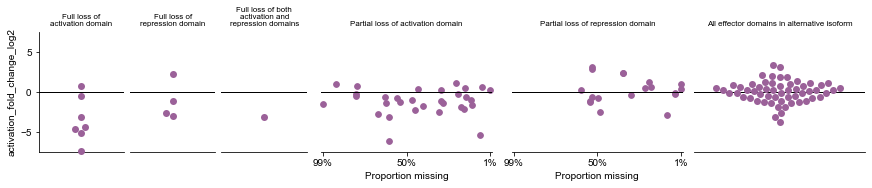

In [6]:
# seperately for repression and activation?
# full loss of activation domain
# full loss of repression domain
# partial loss of each
# loss of both?

from matplotlib import pyplot as plt
COLOR_PURPLE = (155 / 255, 97 / 255, 153 / 255)


df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]

fig, axs = plt.subplots(1, 6, sharey=True, width_ratios=[1, 1, 1, 2, 2, 2])
fig.set_size_inches(w=12, h=2.5)

point_size = 7

axs[0].set_title('Full loss of\nactivation domain',
fontsize=8)
sns.swarmplot(data=df.loc[(df['fraction_of_AD_domains_removed'] == 1) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0))
                           ,
                           :],
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              color=COLOR_PURPLE,
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')

axs[1].set_title('Full loss of\nrepression domain',
fontsize=8)
sns.swarmplot(data=df.loc[(df['fraction_of_RD_domains_removed'] == 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0))

                          , :],
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              color=COLOR_PURPLE,
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')



axs[2].set_title('Full loss of both\nactivation and\nrepression domains',
fontsize=8)
sns.swarmplot(data=df.loc[(df['fraction_of_AD_domains_removed'] == 1) &
                          (df['fraction_of_RD_domains_removed'] == 1), :],
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[2],
              color=COLOR_PURPLE,
              alpha=1)
axs[2].set_xticks([])
axs[2].set_xlabel('')



axs[3].set_title('Partial loss of activation domain',
fontsize=8)
partial_loss = (df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed'] > 0) 
                & (df['fraction_of_AD_domains_removed'] < 1)
                        & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)))
axs[3].scatter(df.loc[partial_loss, 'fraction_of_AD_domains_removed'].values,
               df.loc[partial_loss, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[3].set_xlabel('Proportion missing')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])
#axs[1].set_xticks(range(10, 91, 10), minor=True)


axs[4].set_title('Partial loss of repression domain',
fontsize=8)
partial_loss = (df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed'] > 0)
                  &  (df['fraction_of_RD_domains_removed'] < 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)))

axs[4].scatter(df.loc[partial_loss, 'fraction_of_RD_domains_removed'].values,
               df.loc[partial_loss, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[4].set_xlabel('Proportion missing')
axs[4].set_xlim(1, 0)
axs[4].set_xticks([0.99, 0.5, 0.01])
axs[4].set_xticklabels([f'{x:.0%}' for x in axs[4].get_xticks()])
#axs[1].set_xticks(range(10, 91, 10), minor=True)


axs[5].set_title('All effector domains in alternative isoform',
fontsize=8)
sns.swarmplot(data=df.loc[((df['fraction_of_AD_domains_removed'] == 0) |
                          (df['fraction_of_RD_domains_removed'] == 0) |
                          (df['fraction_of_Bif_domains_removed'] == 0))
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0)) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)) 
                           ,
                           :],
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              color=COLOR_PURPLE,
              alpha=1)
axs[5].set_xticks([])
axs[5].set_xlabel('')


"""


axs[2].set_title('Full domain in\nalternative isoform', fontsize=10)
axs[2].scatter(data.loc[(data['fraction_of_DDI_domains_removed'] == 0), 'domain_n_aa_to_change'].values,
               data.loc[(data['fraction_of_DDI_domains_removed'] == 0), 'Y2H_result_mean'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[2].set_xlabel('Distance of alternative\nsequence from domain\n(number of AA)')

for i in [0]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_yticks(np.linspace(0, 1, 21), minor=True)
axs[0].set_yticklabels(['{:.0%}'.format(y) for y in axs[0].get_yticks()])
axs[0].set_ylabel('Fraction of domain-domain mediated\nPPIs with alternative isoform')
"""
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
fig.savefig('../figures/activation_vs_domain_removal.pdf', bbox_inches='tight')

<AxesSubplot: xlabel='f_disorder_difference', ylabel='activation_fold_change_log2'>

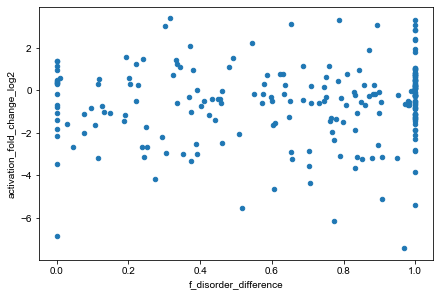

In [7]:
df.plot.scatter(x='f_disorder_difference', y='activation_fold_change_log2')

In [8]:
x_var = 'f_disorder_difference'
y_var = 'activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

PearsonRResult(statistic=0.07470937141695497, pvalue=0.2529507103769356)
SignificanceResult(statistic=0.1071481018046003, pvalue=0.10058356056724486)


In [9]:
x_var = 'f_disorder_difference'
y_var = 'abs_activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

PearsonRResult(statistic=-0.0837288170698881, pvalue=0.1999518676477621)
SignificanceResult(statistic=-0.15538103718127458, pvalue=0.01690066916679032)


<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='activation_fold_change_log2'>

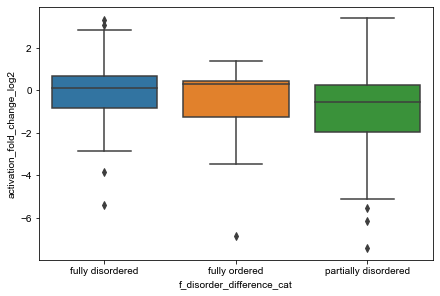

In [10]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='activation_fold_change_log2')

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='abs_activation_fold_change_log2'>

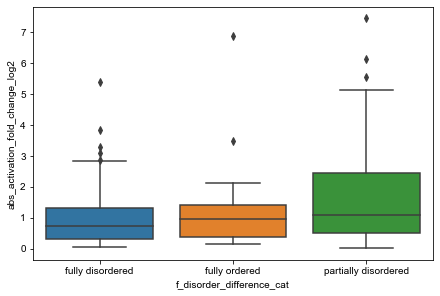

In [11]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='abs_activation_fold_change_log2')

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='abs_activation_fold_change_log2'>

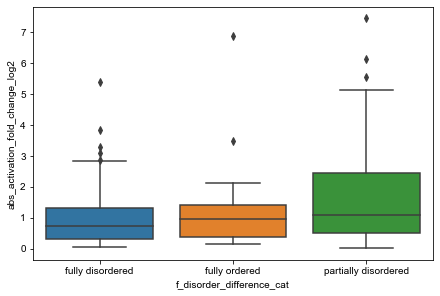

In [12]:
sns.boxplot(data=df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True), :],
            x='f_disorder_difference_cat',
            y='abs_activation_fold_change_log2')

In [13]:
stats.mannwhitneyu(
        df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully ordered'),
               'abs_activation_fold_change_log2'].values,
               df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully disordered')
               , 'abs_activation_fold_change_log2'].values
                          )

MannwhitneyuResult(statistic=842.0, pvalue=0.41349616924081445)

Interestingly, I don't see a difference between disordered and ordered changes and 
activation levels. Check for confounding factors like the size of the changes.

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='aa_seq_pct_id'>

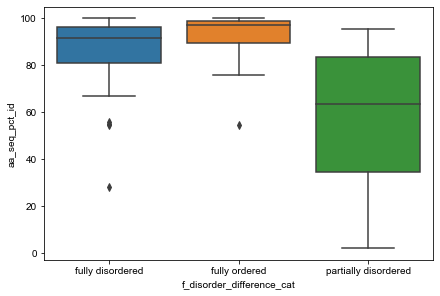

In [14]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='aa_seq_pct_id', 
            order=['fully disordered',
                   'fully ordered',
                   'partially disordered'])

<AxesSubplot: xlabel='f_disorder_difference', ylabel='abs_activation_fold_change_log2'>

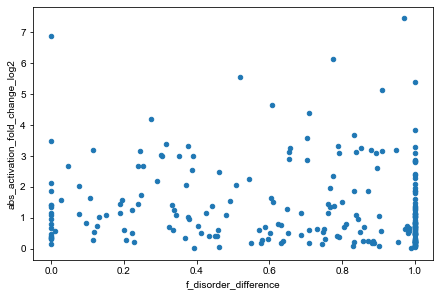

In [15]:
df.plot.scatter(x='f_disorder_difference', y='abs_activation_fold_change_log2')

In [16]:
# x axis as size of change (or aa %id), y axis as act diff, split by dis and ordered

In [17]:
# check examples
(df.loc[df['f_disorder_difference_cat'] == 'fully ordered',
         :]
         .sort_values('abs_activation_fold_change_log2',
                      ascending=False)).head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,ref_iso,alt_iso,f_disorder_difference,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2,fraction_of_AD_domains_removed,insertion_in_AD_domains,fraction_of_RD_domains_removed,insertion_in_RD_domains,fraction_of_Bif_domains_removed,insertion_in_Bif_domains
114,TBPL1,ENSG00000028839,TBP,False,TBPL1|1/2|04H06,TBPL1|2/2|04A07,ENST00000237264|ENST00000613034,ENST00000367871,False,False,True,186,163,6,5,False,True,False,True,False,False,False,False,2.0,12.121212,True,86.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,7.110312,0.246030,-6.864281,TBPL1-1,TBPL1-2,0.0,fully ordered,True,6.864281,NaN,NaN,NaN,NaN,NaN,NaN
224,E2F8,ENSG00000129173,E2F,True,E2F8|1/4|03G03,E2F8|2/4|03A06,ENST00000250024|ENST00000527884|ENST00000620009,NaN,False,True,True,867,842,12,12,False,False,False,False,True,False,False,False,1.0,16.774194,True,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.318486,-0.146185,-3.464671,E2F8-1,E2F8-2,0.0,fully ordered,True,3.464671,NaN,NaN,NaN,NaN,NaN,NaN
332,MLX,ENSG00000108788,bHLH,True,MLX|1/4|11G02,MLX|2/4|01D12,ENST00000435881,NaN,False,True,True,244,240,8,8,False,True,False,True,False,False,False,False,0.0,0.000000,False,88.8,2.0,0.0,2.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.774919,-0.354498,-2.129417,MLX-1,MLX-2,0.0,fully ordered,True,2.129417,NaN,NaN,NaN,NaN,NaN,NaN
11,NFIA,ENSG00000162599,SMAD,True,NFIA|2/5|02G09,NFIA|3/5|02E09,ENST00000403491,ENST00000407417,False,False,True,509,501,11,11,True,False,False,False,False,False,False,False,0.0,0.000000,False,98.2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,4.185884,2.340298,-1.845586,NFIA-2,NFIA-3,0.0,fully ordered,True,1.845586,0.000000,0.0,0.0,0.0,NaN,NaN
260,TFCP2,ENSG00000135457,Grainyhead,True,TFCP2|1/3|03E08,TFCP2|2/3|03H07,ENST00000257915,NaN,False,True,True,502,451,15,14,False,False,True,False,False,True,False,False,0.0,23.502304,True,89.8,12.0,0.0,12.0,12.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.867457,1.466333,-1.401124,TFCP2-1,TFCP2-2,0.0,fully ordered,True,1.401124,0.284916,0.0,0.0,0.0,NaN,NaN


In [18]:
df['f_disorder_difference_cat'].value_counts()

partially disordered    138
fully disordered         79
fully ordered            19
Name: f_disorder_difference_cat, dtype: int64

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='PPI_jaccard'>

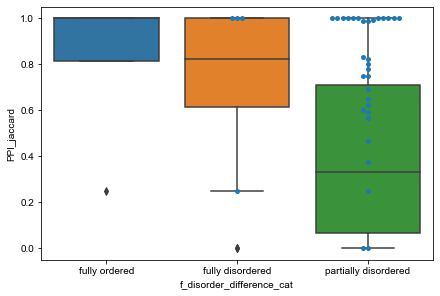

In [19]:
# TODO move PPI stuff to different notebook
sns.swarmplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')
sns.boxplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')

In [20]:
x = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully ordered'),
       'PPI_jaccard'].values
y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully disordered'),
       'PPI_jaccard'].values
stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=79.0, pvalue=0.37652470660703774)

<AxesSubplot: xlabel='f_disorder_difference', ylabel='PPI_jaccard'>

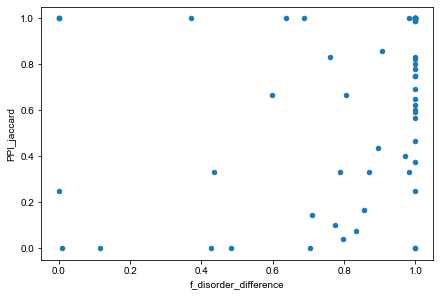

In [21]:
(df.loc[(df['n_positive_PPI_ref'] > 0) & 
        (df['n_positive_PPI_alt'] > 0), 
        :].plot.scatter(x='f_disorder_difference', y='PPI_jaccard'))

In [22]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

PearsonRResult(statistic=0.21399512981204669, pvalue=0.10363675707736489)
SignificanceResult(statistic=0.2776247795047743, pvalue=0.033263028045941105)


In [23]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              (df['f_disorder_difference'] > 0) &
              (df['f_disorder_difference'] < 1) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

PearsonRResult(statistic=0.2689603958369194, pvalue=0.2037765945144831)
SignificanceResult(statistic=0.3193811981797855, pvalue=0.12818960541736044)
